In [1]:
%load_ext autoreload
%autoreload 2
import astropy.units as u
import astropy.constants as const
from astroduet.bbmag import bb_abmag_fluence, bb_abmag, gettempbb
import numpy as np
from matplotlib import pyplot as plt
from astropy.table import Table

import astroduet.config as config
from astroduet.background import background_pixel_rate

from astropy.visualization import quantity_support
import matplotlib
font = {'family' : 'sans',
        'weight' : 'bold',
        'size'   : 18}

matplotlib.rc('font', **font)

In [2]:
plt.rcParams['figure.figsize'] = [12,9]

In [3]:
# Telescope setup, just used for bandpass here
duet = config.Telescope()
duet.info()
bandone=duet.bandpass1
bandtwo = duet.bandpass2

-----
DUET Telescope State:
Physical Entrance Pupil: 26.0 cm
Effective EPD: 24.2 cm
Effective Area: 459.9605804120816 cm2
Transmission Efficiency: 0.8166518036622619

Pixel size: 6.4 arcsec
PSF FWHM: 5.0 arcsec
Pointing jitter: 5.0 arcsec
Effective PSF FWHM: 7.0710678118654755 arcsec
N_eff: 3.3581908798935647

Band 1: {'eff_wave': <Quantity 202.56878682 nm>, 'eff_width': <Quantity 53.32814342 nm>}
Bandpass 1: [175.90471511 229.23285853] nm
Band 2: {'eff_wave': <Quantity 281.7531854 nm>, 'eff_width': <Quantity 68.16239088 nm>}
Bandpass 2: [247.67198996 315.83438085] nm


Dark current: 0.0115 ph / s
Read noise (RMS per read): 7
-----


In [4]:
# Blackbody settings
bbtab = Table([[1.e4, 2.e4, 5.e4, 1.e5, 2.e5]*u.K,np.zeros(5),np.zeros(5)], names=('temp','mag_D1','mag_D2'))
snr = np.arange(5,100)
stat_err = 2.5*np.log10(1.+1./snr)
sys_err = [0.05,0.1,0.2] # Random guess...

In [5]:
# Get blackbody magnitudes (scale is random)
for i, temp in enumerate(bbtab['temp'].quantity):
    mag1, mag2 = bb_abmag(bbtemp=temp, bandone=bandone, bandtwo=bandtwo, swiftmag=20*u.ABmag, val=True)
    bbtab['mag_D1'][i], bbtab['mag_D2'][i] = mag1, mag2

In [6]:
# Fit blackbody temperatures:
bbtemps = np.zeros([len(sys_err),len(bbtab['temp']),len(snr),2])*u.K
for k, syserr in enumerate(sys_err):
    for i,temp in enumerate(bbtab['temp']):
        for j,staterr in enumerate(stat_err):
            fittemp, fittemperr = gettempbb(bandone=bandone, bandtwo=bandtwo,
                                        magone=bbtab['mag_D1'][i]*u.ABmag, magtwo=bbtab['mag_D2'][i]*u.ABmag,
                                        magone_err=np.sqrt(staterr**2 + syserr**2)*u.ABmag,
                                        magtwo_err=np.sqrt(staterr**2 + syserr**2)*u.ABmag, bbtemp_init=temp)
            bbtemps[k,i,j] = fittemp, fittemperr

In [7]:
# DUET colors as function of temperature
bbtab_large = Table([np.geomspace(5e3,30e3,num=50)*u.K,np.zeros(50),
                     np.zeros(50),np.zeros(50), np.zeros(50), np.zeros(50)],
                    names=('temp','mag_D1','mag_D2','deltamag', 'fit_temp', 'fit_err'))
for i, temp in enumerate(bbtab_large['temp'].quantity):
    mag1, mag2 = bb_abmag(bbtemp=temp, bandone=bandone, bandtwo=bandtwo, swiftmag=20*u.ABmag, val=True)
    bbtab_large['mag_D1'][i], bbtab_large['mag_D2'][i], bbtab_large['deltamag'][i] = mag1, mag2, mag1-mag2

In [8]:
# DUET colors as function of temperature
staterr = stat_err[6]
sys_err = 0.1
bbtab_large = Table([np.geomspace(5e3,30e3,num=50)*u.K,np.zeros(50),
                     np.zeros(50),np.zeros(50), np.zeros(50), np.zeros(50)],
                    names=('temp','mag_D1','mag_D2','deltamag', 'fit_temp', 'fit_err'))

for i, temp in enumerate(bbtab_large['temp'].quantity):

    mag1, mag2 = bb_abmag(bbtemp=temp, bandone=bandone, bandtwo=bandtwo, swiftmag=20*u.ABmag, val=True)

    fit_temp, fit_err = gettempbb(bandone=bandone, bandtwo=bandtwo,
                                        magone=mag1*u.ABmag, magtwo=mag2*u.ABmag,
                                        magone_err=np.sqrt(staterr**2 + syserr**2)*u.ABmag,
                                        magtwo_err=np.sqrt(staterr**2 + syserr**2)*u.ABmag,
                                        bbtemp_init=temp.value)
    print(fit_temp)
    bbtab_large['fit_temp'][i] = fit_temp.value
    bbtab_large['fit_err'][i] = fit_err.value
    

5175.029582701757 K
5355.302766902227 K
5542.11238345573 K
5735.719949551299 K
5936.396712818993 K
6144.423933100464 K
6360.093191670688 K
6583.706729584808 K
6815.577816639854 K
7056.031152262345 K
7305.403299451185 K
7564.043152712152 K
7832.312440714893 K
8110.586264183685 K
8399.253669309159 K
8698.718256748047 K
9009.39882607945 K
9331.73005542294 K
9666.163215816629 K
10013.166919913965 K
10373.227904600297 K
10746.851847260048 K
11134.564215641149 K
11536.911151563681 K
11954.460389089949 K
12387.802208199802 K
12837.550425479032 K
13304.343423814264 K
13788.845223571188 K
14291.746598199894 K
14813.766237651032 K
15355.651963386108 K
15918.1819991188 K
16502.16630173524 K
17108.447957110446 K
17737.90464576965 K
18391.450183550907 K
19070.036142615892 K
19774.653558342918 K
20506.334727832516 K
21266.15510597175 K
22055.23530524418 K
22874.74320576672 K
23725.8961823614 K
24609.9634558632 K
25528.26857631575 K
26482.192046228152 K
27473.174092647354 K
28502.71759747291 K
29572.

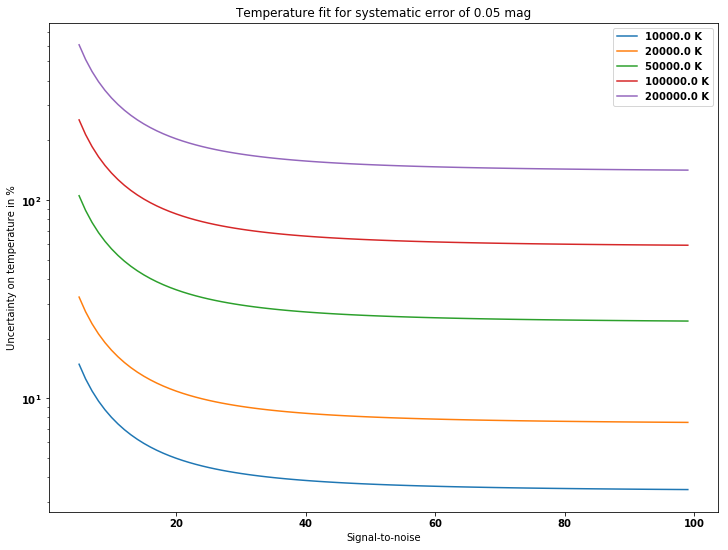

In [9]:
for i,temp in enumerate(bbtab['temp']):
    #plt.errorbar(snr,bbtemps[i,:,0],yerr=bbtemps[i,:,1])
    plt.plot(snr,bbtemps[0,i,:,1]/bbtemps[0,i,:,0]*100,label=str(temp)+' K')

#plt.ylim(0,1e6)
plt.yscale('log')
plt.ylabel('Uncertainty on temperature in %')
plt.xlabel('Signal-to-noise')
plt.legend()
plt.title('Temperature fit for systematic error of 0.05 mag')
plt.show()

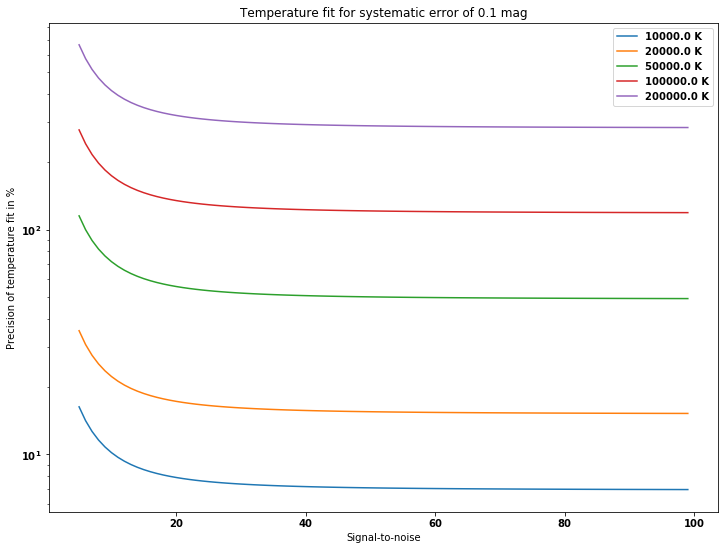

In [10]:
for i,temp in enumerate(bbtab['temp']):
    #plt.errorbar(snr,bbtemps[i,:,0],yerr=bbtemps[i,:,1])
    plt.plot(snr,bbtemps[1,i,:,1]/bbtemps[1,i,:,0]*100,label=str(temp)+' K')

#plt.ylim(0,1e6)
plt.yscale('log')
plt.ylabel('Precision of temperature fit in %')
plt.xlabel('Signal-to-noise')
plt.legend()
plt.title('Temperature fit for systematic error of 0.1 mag')
plt.show()

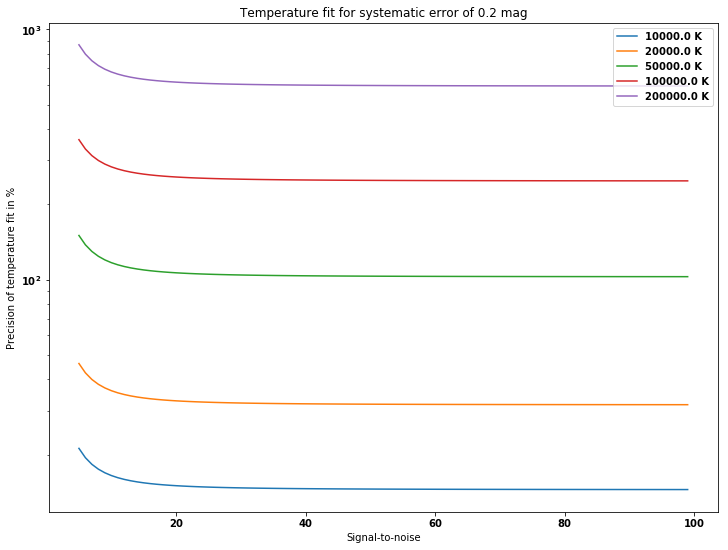

In [11]:
for i,temp in enumerate(bbtab['temp']):
    #plt.errorbar(snr,bbtemps[i,:,0],yerr=bbtemps[i,:,1])
    plt.plot(snr,bbtemps[2,i,:,1]/bbtemps[2,i,:,0]*100,label=str(temp)+' K')

#plt.ylim(0,1e6)
plt.yscale('log')
plt.ylabel('Precision of temperature fit in %')
plt.xlabel('Signal-to-noise')
plt.legend()
plt.title('Temperature fit for systematic error of 0.2 mag')
plt.show()

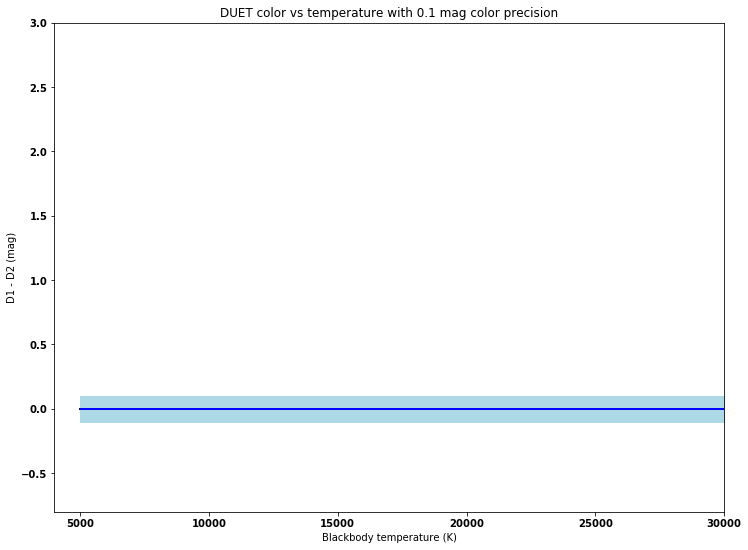

In [12]:
plt.fill_between(bbtab_large['temp'], bbtab_large['deltamag']-0.1, bbtab_large['deltamag']+0.1, color='lightblue')
plt.plot(bbtab_large['temp'],bbtab_large['deltamag'],linewidth=2, color='blue')

plt.xlabel('Blackbody temperature (K)')
plt.ylabel('D1 - D2 (mag)')
plt.ylim(-0.8,3)
plt.xlim(4e3,30e3)
#plt.xscale('log')
plt.title('DUET color vs temperature with 0.1 mag color precision')
plt.show()

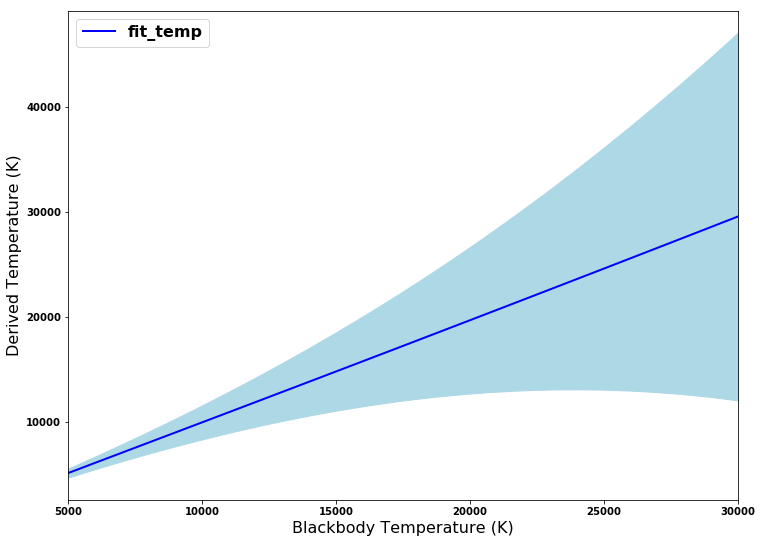

In [13]:
plt.fill_between(bbtab_large['temp'], bbtab_large['fit_temp']-bbtab_large['fit_err'],
                 bbtab_large['fit_temp']+bbtab_large['fit_err'], color='lightblue')
plt.plot(bbtab_large['temp'],bbtab_large['fit_temp'],linewidth=2, color='blue')


plt.xlim(5e3,30e3)
#plt.yscale('log')
plt.ylabel('Derived Temperature (K)', fontsize=16)
plt.xlabel('Blackbody Temperature (K)', fontsize=16)
plt.legend(fontsize=16,loc=2)
#plt.title('Temperature fit for systematic error of 0.2 mag')
plt.show()

Text(0.5, 0, 'Blackbody Temperature (K)')

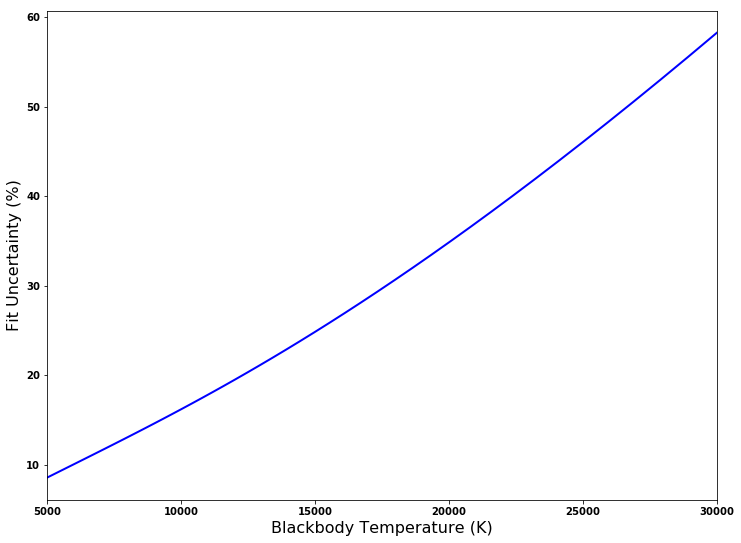

In [14]:
# plt.fill_between(bbtab_large['temp'], bbtab_large['fit_temp']-0.5*bbtab_large['fit_err'],
#                  bbtab_large['fit_temp']+0.5*bbtab_large['fit_err'], color='lightblue')
frac_err = 100*(bbtab_large['temp'] - bbtab_large['fit_temp']) / bbtab_large['temp']

plt.plot(bbtab_large['temp'],100*bbtab_large['fit_err'] / bbtab_large['temp'],linewidth=2, color='blue')


plt.xlim(5e3,30e3)
#plt.yscale('log')
plt.ylabel('Fit Uncertainty (%)', fontsize=16)
plt.xlabel('Blackbody Temperature (K)', fontsize=16)
#plt.legend(fontsize=16,loc=2)

In [15]:
print(snr[6])

11
